<center><H1>Data Scientist vs. Data Analysts vs. Business Analysts<H1></center>
<hr>

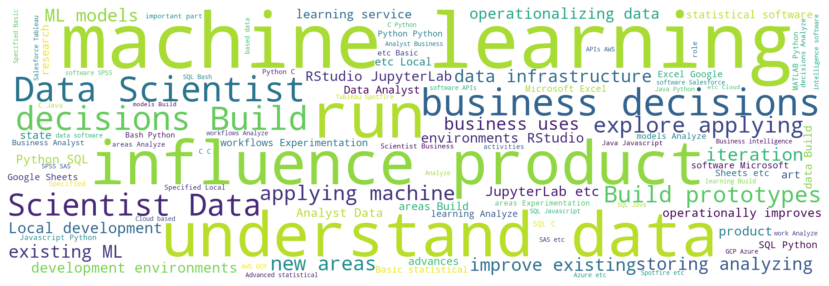

<p style="font-size:13pt">
If you have an analytical mindset and love decoding data to tell a story, you may want to consider a career as a data analyst or data scientist. After all, data analysts and data scientists are two of the hottest jobs in tech (and pay pretty well, too). Harvard Business Review even awarded “data scientist” the title of “sexiest job of the 21st century.” <br><br>Data science and analytics (DSA) jobs are in high demand. According to Forbes, “…by 2020, the number of data science and analytics job listings is projected to grow by nearly 364,000 listings to approximately 2,720,000.” They aren’t the easiest positions to fill, either. Forbes goes on to say that DSA jobs “remain open an average of 45 days, five days longer than the market average.”<br><br> 
But what is the difference between data analytics vs. data science, and how do the two job roles differ?</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import combinations
from collections import Counter
import warnings
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import wordcloud

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
sns.color_palette("rocket")
%matplotlib inline

pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Data Cleaning and Transformation
After cleaning, transforming and splitting the provided data(`kaggle_survey_2020_responses.csv`), we get 4 seperate DataFrames, namely:
1. *questions*: Questions asked in the survey
2. *responses*: Responses entered by the respondents
3. *professionals*: Responses by professional respondents
4. *non professionals*: Responses by non-professional respondents

> According to the [Survey Methodology](../input/kaggle-survey-2020/supplementary_data/kaggle_survey_2020_methodology.pdf) provided with the Data, a respondent can be categorised as `Non Professional` if the respondent is either a 
- *student* or 
- *unemployed* or
- *has never spent money on cloud services* 


In [ ]:
df = pd.read_csv('../input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

questions = df.loc[:0]

multiple_options_questions = set()
multiple_options_questions_A_B = set()

for q in list(questions.filter(regex=("Q\d+_Part_\d+")).columns):
    multiple_options_questions.add(int(q.split("_")[0][1:]))
for q in list(questions.filter(regex=("Q\d+_A_Part_\d+")).columns):
    multiple_options_questions_A_B.add(int(q.split("_")[0][1:]))

def extract_question(row):
    row = list(row)
    return row[0].split("-")[0].strip()

for i in list(multiple_options_questions):
    questions[f"Q{i}"] = questions.filter(regex=(f"Q{i}_Part_\d+")).apply(lambda row: extract_question(row.values.astype(str)), axis=1)
    
for i in list(multiple_options_questions_A_B):
    questions[f"Q{i}_A"] = questions.filter(regex=(f"Q{i}_A_Part_\d+")).apply(lambda row: extract_question(row.values.astype(str)), axis=1)
    questions[f"Q{i}_B"] = questions.filter(regex=(f"Q{i}_B_Part_\d+")).apply(lambda row: extract_question(row.values.astype(str)), axis=1)

questions.drop(columns=questions.filter(regex=("Q\d+_Part_\d+")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_A_Part_\d+")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_B_Part_\d+")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_A_OTHER")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_B_OTHER")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_OTHER")).columns, inplace=True)

questions= questions.transpose().iloc[1:]
questions.columns = ['Question']
questions.sort_index(inplace=True)

df = df[1:]
df.reset_index(inplace=True)

### Marking all the missing values as `Not Specified`

df.replace(to_replace=np.nan, value="Not Specified", inplace=True)

### Grouping responses for questions with more than one selected options

def group(row):
    row = list(row)
    result = list()
    for val in row:
        if val == "Not Specified":
            pass
        else:
            result.append(val.strip())
    return ";".join(result)

responses = pd.DataFrame()
for i in range(1, 40):
    if i in list(multiple_options_questions):
        responses[f"Q{i}"] = df.filter(regex=(f"Q{i}_Part_\d+")).apply(lambda row: group(row.values.astype(str)), axis=1)
    elif i in list(multiple_options_questions_A_B):
        responses[f"Q{i}_A"] = df.filter(regex=(f"Q{i}_A_Part_\d+")).apply(lambda row: group(row.values.astype(str)), axis=1)
        responses[f"Q{i}_B"] = df.filter(regex=(f"Q{i}_B_Part_\d+")).apply(lambda row: group(row.values.astype(str)), axis=1)
    else:
        responses[f"Q{i}"] = df[f"Q{i}"]

### Splitting the respondents into two categories: `Professional` and `Non Professional`

non_prof_index = responses[(responses['Q5']=='Student') | 
                           (responses['Q5']=='Currently not employed') | 
                           (responses['Q5']=='Other') |  
                           (responses['Q5']=='Not Specified') |
                           (responses['Q25']=='$0 ($USD)')].index

type_of_job_role =  list()
for index, row in responses.iterrows():
    if index in list(non_prof_index):
        type_of_job_role.append("Non Professional")
    else:
        type_of_job_role.append("Professional")
responses['type of Job Role'] = type_of_job_role

non_professional = responses[responses['type of Job Role']=="Non Professional"]
professional = responses[responses['type of Job Role']=="Professional"]

# Part B of the questions are supplement questions rephrased for non professional respondents

non_professional.drop(columns=non_professional.filter(regex=("Q\d+_A")).columns, inplace=True)
professional.drop(columns=professional.filter(regex=("Q\d+_B")).columns, inplace=True)

questions.to_csv('./questions.csv')
responses.to_csv('./responses.csv', index=False)
professional.to_csv('./professional.csv', index=False)
non_professional.to_csv('./non_professional.csv', index=False)

# Data
<p style="font-size:13pt">
The data used for this analysis focuses on the professionals working as:
<ul style="font-size:13pt">    
<li>Data Scientists 
<li>Data Analysts 
<li>Business Analysts 
</ul>
</p>

In [ ]:
professionals = pd.read_csv('professional.csv')
questions = pd.read_csv('questions.csv')

questions.columns = ["Question Number", "Question"]
questions.set_index(keys="Question Number", inplace=True)

ed_ind = professionals[
    (professionals['Q4']=="Master’s degree") |
    (professionals['Q4']=="Bachelor’s degree") |
    (professionals['Q4']=="Doctoral degree")
].index
professionals = professionals.iloc[list(ed_ind)]
professionals.reset_index(inplace=True)
professionals.drop(columns=['index'], inplace=True)

ind = professionals[
    (professionals['Q5']=="Data Scientist") |
    (professionals['Q5']=="Data Analyst") |
    (professionals['Q5']=="Business Analyst")
].index

data_professionals = professionals.iloc[list(ind)]
data_professionals.reset_index(inplace=True)
data_professionals.drop(columns=['index'], inplace=True)
data_professionals['count'] = 1

df = data_professionals.groupby("Q5")
data_scientists = df.get_group("Data Scientist")
data_analysts = df.get_group("Data Analyst")
business_analysts = df.get_group("Business Analyst")

# Job Role
<p style="font-size:13pt">In all data related jobs there’s a certain amount of skills overlap.<br><br>
Data Analysts perform a variety of tasks around collecting, organizing, and interpreting statistical information. Their mainly responsible for using data to identify efficiencies, problem areas, and possible improvements.<br><br>
The actual role of the Data Scientist is one of the most debated — probably because the role varies considerably from company to company. A Data Scientist is a person who utilizes Machine Learning algorithms to create a model from data that ultimately helps to make a business more efficient. But a Data Scientist is also expected to take on the mantle of an Analyst as well.<br><br>
The line between Business Analysts and Data Analysts has become so blurred that they’re essentially the same thing. Both use their reports and analyses to help management make decisions and set goals. 
</p>

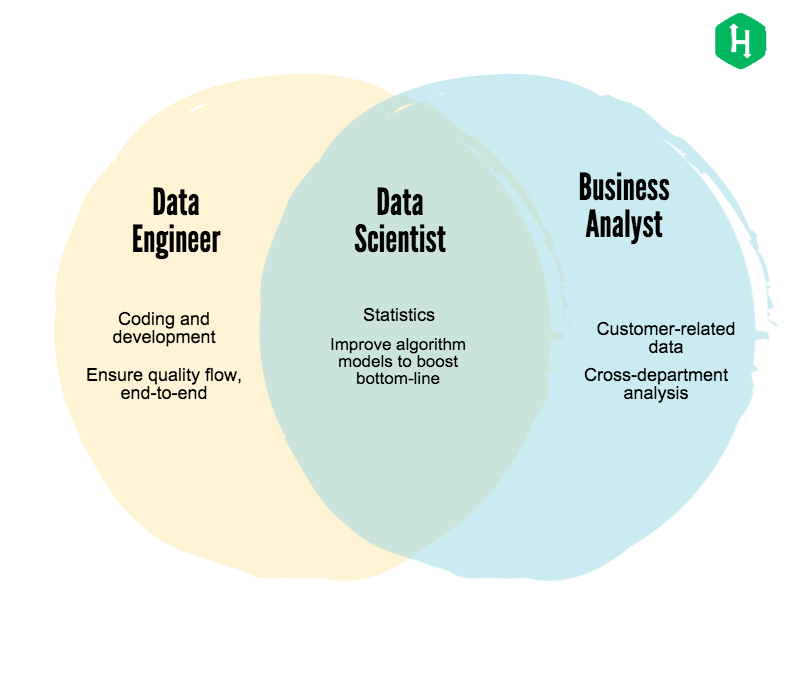

<p style="font-size:13pt">
    Here below we have the top three tasks or roles respondents have mentioned that they perform in their jobs as <em>Data Professionals</em>
</p>

In [ ]:
titles = ["Data Scientist", "Data Analyst", "Business Analyst"]
df_grouped = data_professionals[data_professionals["Q3"]=="United States of America"].groupby("Q5")
job_role_dic = dict()
top3 = pd.DataFrame(columns=titles)
for title in titles:
    df = df_grouped.get_group(title)
    count = Counter()
    for row in df['Q23']:
        try:
            row_list = row.split(";")
        except:
            pass
        count.update(Counter(combinations(row_list, 1)))
    dic = dict()    
    for key,value in count.most_common(10):
        dic[key[0]] = value
        
    top3[title] = list(dic.keys())[:3]
    
fig = go.Figure(data=[go.Table(
    header=dict(values=list(top3.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[top3["Data Scientist"], top3["Data Analyst"], top3["Business Analyst"]],
               fill_color='lavender',
               align='left'))
])
fig.update_layout(
    title={'text': "Primary roles performed by Data Professionals",
           'x':0.5,
          }
)
fig.update_layout(height=500, 
                  width=750,)
fig.show()

# Education

<p style="font-size:13pt">
    While it may not be the case everywhere, but to bag a Data Scientist job, a master's degree is the minimum requirement at every reputed company.<br>
    Most of the Data Scientists have a Master's degree. It can also be noted that <strong>almost 90%</strong> of the PhD or Doctoral degree holders are Data Scientists.<br>
    This maybe due to the level of expertise expected from a Data Scientist to effectively achieve the goals of the organisation.<br>
    
</p>    

In [ ]:
fig = px.parallel_categories(data_professionals[['Q5', 'Q4']], 
                       template="seaborn", 
                       labels={"Q5":"Job Title", "Q4":"Highest Degree"}, 
                       title="Job Title vs. Highest Degree"
                      )
fig.update_layout(height=500, 
                  width=750,)
fig.show()

# Coding Experience

<blockquote style="font-size:14pt">“A data scientist is someone who is better at statistics than any software engineer and better at software engineering than any statistician.”</blockquote>
<p style="font-size:13pt"> A Data Scientist is expected to have strong computer science and programming skills as a major part of the job involves around machine learning and deploying the models to make them useable in production.
    <br> Analysts need not to be as skilled programmers as scientists but knowledge of a statistical language like R or Python helps along the way.<br><br>
    Here we can see that <strong>more than 50%</strong> of the Data Scientists have coding experience of between <strong>3 to 10 years</strong>.<br> The top 50% of the Data Analysts only have 1 to 5 years of coding expereince.<br> This plunges down even more (to 0 to 2 years) for Business Analysts.
    </p>

In [ ]:
coding_sorted_list = ['Not Specified', 
               'I have never written code', 
               '< 1 years', 
               '1-2 years', 
               '3-5 years', 
               '5-10 years', 
               '10-20 years', 
               '20+ years']

pivot_coding = pd.pivot_table(data=data_professionals, 
                       values='count', 
                       index="Q5", 
                       columns="Q6", 
                       aggfunc=np.sum).loc[titles][coding_sorted_list]

df_grouped = data_professionals.groupby("Q5")
coding_exp_dic = dict()
for title in titles:
    df = df_grouped.get_group(title)
    df_title = pivot_coding.loc[pivot_coding.index==title].apply(lambda x: x*100/df.shape[0])
    coding_exp_dic[title]=df_title
pivot_coding_frac= pd.concat(coding_exp_dic.values())

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 5))
fig.suptitle("Coding Experience Distribution")
sns.heatmap(ax=axes[0], data = coding_exp_dic["Data Scientist"], cmap="viridis", annot=coding_exp_dic["Data Scientist"])
sns.heatmap(ax=axes[1], data = coding_exp_dic["Data Analyst"], cmap="viridis", annot=coding_exp_dic["Data Analyst"])
sns.heatmap(ax=axes[2], data = coding_exp_dic["Business Analyst"], cmap="viridis", annot=coding_exp_dic["Business Analyst"])
plt.show()

# ML Experience

<p style="font-size:13pt">Data Professionals are a generalist in a variety of different areas, but have deep domain experience in one particular area. For a Data Scientist, that deep experience is probably in Statistics and Machine Learning. Thus Data Scientists have the most experience with Machine Learning.
</p>

In [ ]:
ml_sorted_list = ['Not Specified', 
               'I do not use machine learning methods', 
               'Under 1 year', 
               '1-2 years',
               '2-3 years',
               '3-4 years',
               '4-5 years',
               '5-10 years', 
               '10-20 years', 
               '20 or more years']

pivot_ml = pd.pivot_table(data=data_professionals, 
                       values='count', 
                       index="Q5", 
                       columns="Q15", 
                       aggfunc=np.sum).loc[titles][ml_sorted_list]

titles = ["Data Scientist", "Data Analyst", "Business Analyst"]
df_grouped = data_professionals.groupby("Q5")
df_dic_ml = dict()
for title in titles:
    df = df_grouped.get_group(title)
    df_title = pivot_ml.loc[pivot_ml.index==title].apply(lambda x: x*100/df.shape[0])
    df_dic_ml[title]=df_title
pivot_ml_frac= pd.concat(df_dic_ml.values())

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 5))
fig.suptitle("Machine Learning Experinece")
sns.heatmap(ax=axes[0], data = df_dic_ml["Data Scientist"], cmap="viridis", annot=df_dic_ml["Data Scientist"])
sns.heatmap(ax=axes[1], data = df_dic_ml["Data Analyst"], cmap="viridis", annot=df_dic_ml["Data Analyst"])
sns.heatmap(ax=axes[2], data = df_dic_ml["Business Analyst"], cmap="viridis", annot=df_dic_ml["Business Analyst"])
plt.show()

# How Much Do They Earn?

<p style="font-size:13pt">
    According to Glassdoor, the average annual salary for a data scientist is \$162,000 and for a data analyst it is $84,000.<br>
    Along with technical and analytical skills, the candidate is expected to have great soft skills too.
    Finding someone who has the ideal blend of right-brain and left-brain skills is not an easy task, which is one reason why data professionals are paid well.<br><br>
    According to the survey data,<br>
    The median salary for a Data Scientist in US is \$137,499 per annum. Whereas in India, the median salary for a Data Scientist is just \$12,499 per annum.<br>
    In the US, median salaries for Data Analysts and Business Analysts are \$85k and \$95k respectively.<br><br>
    In India, professionals are highly uderpaid and are expected to have the same skill sets and do the same tasks as their American counterparts.</p>

In [ ]:
salary_ind = data_professionals[data_professionals['Q24']=="Not Specified"].index
salary_df = data_professionals.copy()
salary_df.drop(index=salary_ind, inplace=True)

salary = salary_df['Q24'].apply(lambda x: x.replace('$', '').replace(',', '').replace('> ', ''))

def avg_sal(sal_range):
    try:
        min_sal = int(sal_range.split("-")[0])
        max_sal = int(sal_range.split("-")[1])
        return (max_sal+min_sal)/2
    except:
        return int(sal_range.split("-")[0])
salary_df['Salary Estimate'] = salary.apply(avg_sal)

salary_india_usa = salary_df.loc[salary_df[(salary_df["Q3"]=="India") | (salary_df["Q3"]=="United States of America")].index]

In [ ]:
fig = px.box(salary_india_usa, x="Q5", 
             y="Salary Estimate", 
             color="Q3", 
             template="seaborn",
             labels={"Q3":"Country"},
             title="Country-wise Salary Estimates for Data Professionals"
            )
fig.update_layout(legend=dict(orientation="h",
                             yanchor="bottom",
                             y=1.02,
                             xanchor="right",
                             x=1))

fig.update_layout(height=500, 
                  width=750,)
fig.show()




<p style="font-size:13pt">
    It is a general rule of thumb, the more advanced your degrees are, the higher are the chances of getting a better salary package.</p>

In [ ]:
fig = px.box(salary_df, 
             x="Q4", 
             y="Salary Estimate", 
             color="Q5", 
             template="seaborn",
             labels={"Q5":"Job Title", "Q4":"Highest level of Education"},
             title="Estimated Annual Salaries According to the Highest Level of Education"
            )
fig.update_layout(legend=dict(orientation="h",
                             yanchor="bottom",
                             y=1.02,
                             xanchor="right",
                             x=1))
fig.update_layout(height=500, 
                  width=750,)
fig.show()

fig1 = px.box(salary_india_usa, 
              x="Q4", 
              y="Salary Estimate", 
              color="Q5", 
              template="seaborn", 
              facet_col="Q3",
             labels={"Q5":"Job Title", "Q4":"Highest level of Education"},)
fig1.update_layout(showlegend=False)
fig1.update_layout(height=500, 
                  width=750,)
fig1.show()

# Primary Tool for Data Analysis

<p style="font-size:13pt">
    Data Scientists and Analysts are expected to have strong programming foundations. A typical response of programmer for any problem is to whip up some code.<br> Same is applicable here, Data Scientists and Data Analysts prefer using ther <strong>local development environment</strong> such as R Studio or Jupyter notebooks.<br>
    A Business Analyst on the other hand, uses basic statistical softwares such as Microsoft Excel and Business Intelligence tools such as Power BI or Tableau.
    </p>
    

In [ ]:
tool_df = data_professionals.drop(index=list(data_professionals[(data_professionals['Q38']=="Not Specified") | 
                                                                (data_professionals['Q38']=="Other")].index))

tool_df = tool_df[tool_df["Q3"]=="United States of America"]
tool_df["Q38"] = tool_df["Q38"].apply(lambda x: x.split("(")[0].strip())

fig = px.parallel_categories(tool_df[[ 'Q5', 'Q38']], 
                             template="seaborn",
                             labels={"Q5":"Job Title", "Q38":"Primary tool used for Data Analyis"},
                             title="Primary tools used for Data Analysis"
                            )
fig.update_layout(autosize=True)
fig.update_layout(height=500, 
                  width=750,)
fig.show()